# Problem Statement

**How can autoencoders be used to extract hidden features in data to improve clustering results?**

# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tensorflow.keras import layers, models
from tensorflow.keras.utils import set_random_seed

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score,
                             confusion_matrix, calinski_harabasz_score,
                             silhouette_score, davies_bouldin_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.datasets import load_iris, load_wine
from ucimlrepo import fetch_ucirepo 

# Custom Functions

In [2]:
def compute_similarity_matrix(data, metric='cosine'):
    """Compute similarity matrix for the given data."""
    
    if metric == 'cosine':
        similarity_matrix = cosine_similarity(data)
    elif metric == 'euclidean':
        similarity_matrix = 1 / (1 + euclidean_distances(data))
    else:
        raise ValueError("Unsupported similarity metric. Choose 'cosine' or 'euclidean'")
    
    return similarity_matrix

In [3]:
set_random_seed(420)

def cnn_autoencoder(similarity_matrix):
    """Perform cnn autoencoding on the input similarity matrix"""
    input_shape = (similarity_matrix.shape[1], 1)
    input_layer = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv1D(64, 3, activation='tanh', padding='same')(input_layer)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(128, 3, activation='tanh', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(256, 3, activation='tanh', padding='same')(x)
    encoded = layers.MaxPooling1D(2, padding='same')(x)

    # Decoder
    x = layers.Conv1D(256, 3, activation='tanh', padding='same')(encoded)
    x = layers.UpSampling1D(2)(x)

    x = layers.Conv1D(128, 3, activation='tanh', padding='same')(x)
    x = layers.UpSampling1D(2)(x)

    x = layers.Conv1D(64, 3, activation='tanh', padding='same')(x)
    x = layers.UpSampling1D(2)(x)

    decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)

    decoded = layers.Cropping1D(cropping=(0, decoded.shape[1] -
                                          input_shape[0]))(decoded)

    autoencoder = models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(similarity_matrix,
                    similarity_matrix,
                    epochs=10,
                    batch_size=16,
                    shuffle=True)

    reconstructed_data = autoencoder.predict(similarity_matrix)

    encoder = models.Model(input_layer, encoded)
    encoded_features = encoder.predict(similarity_matrix)

    return encoded_features, reconstructed_data, encoder, autoencoder

In [4]:
def purity_score(y_true, y_pred):
    """Compute the class purity"""
    
    cm = confusion_matrix(y_true, y_pred)
    total_samples = len(y_true)
    purity = 0
    for cluster in cm.T:
        purity += max(cluster)
    purity /= total_samples
    return purity

In [5]:
def kmeans_clustering(features, labels, name):
    """Perform KMeans clustering"""
    
    k = np.unique(labels).shape[0]

    kmeans = KMeans(
            n_clusters=k, random_state=1337).fit(features)
    kmeans_labels = kmeans.labels_

    kmeans_results = {
        "Input Data": name,
        "Purity (KMeans)":
            purity_score(labels, kmeans_labels),
        "AMI (KMeans)":
            adjusted_mutual_info_score(labels, kmeans_labels),
        "ARI (KMeans)":
            adjusted_rand_score(labels, kmeans_labels),
        "Calinski-Harabasz Index (KMeans)":
            calinski_harabasz_score(features, kmeans_labels),
        "Silhouette Coefficient (KMeans)":
            silhouette_score(features, kmeans_labels),
        "Davies-Bouldin Index (KMeans)":
            davies_bouldin_score(features, kmeans_labels)
    }

    return kmeans_results, kmeans_labels

In [6]:
def wards_clustering(features, labels, name):
    """Perform Ward's method clustering"""
    k = np.unique(labels).shape[0]  
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    ward_labels = agg.fit_predict(features)
    
    ward_results = {
        "Input Data": name,
        "Purity (Wards)":
            purity_score(labels, ward_labels),
        "AMI (Wards)":
            adjusted_mutual_info_score(labels, ward_labels),
        "ARI (Wards)":
            adjusted_rand_score(labels, ward_labels),
        "Calinski-Harabasz Index (Wards)":
            calinski_harabasz_score(features, ward_labels),
        "Silhouette Coefficient (Wards)":
            silhouette_score(features, ward_labels),
        "Davies-Bouldin Index (Wards)":
            davies_bouldin_score(features, ward_labels)
    }
    
    return ward_results, ward_labels

In [7]:
def encode_labels(labels, encode=True):
  """
  Encodes class labels if specified, otherwise returns the labels as a 1D array.
  """

  if encode:
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels.to_numpy().ravel())
  else:
    # Ensure labels are a 1D array using numpy.asarray
    return labels.to_numpy().ravel()

In [8]:
def plot_clusters(features, labels, ax, title, filename=None):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(features)

    # Define the hex colors
    color1 = "#F15F6C"
    color2 = "#F9C3D2"
    
    # Create a custom colormap
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])
    
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=custom_cmap)
    
    if filename:
      plt.savefig(filename, transparent=True)
        
    ax.set_title(title)
    
    return sc

# K-Means

## Wine

In [9]:
# Load Wine Data 
wine = load_wine()

features = wine.data
labels = wine.target

### Raw Data (Baseline)

In [10]:
kmeans_raw, kmean_labels_raw = kmeans_clustering(features, labels, 'Raw Data')

### Encoded Data

In [11]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [12]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.1140
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [13]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [14]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [15]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [16]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [17]:
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 23, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 46, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 92, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 184, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 184, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 178, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [19]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [20]:
print('Summary of KMeans Results (Wine Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (Wine Dataset)


,Input Data,Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.685393,0.416759,0.351772,497.004876,0.559582,0.549558
1,Decoded Data,0.758427,0.698940,0.554040,27.079481,0.157769,2.105125
2,Decoded Data,0.634831,0.379635,0.221583,1300.910550,0.779441,0.400527


Plot of KMeans Clustering (Wine Dataset


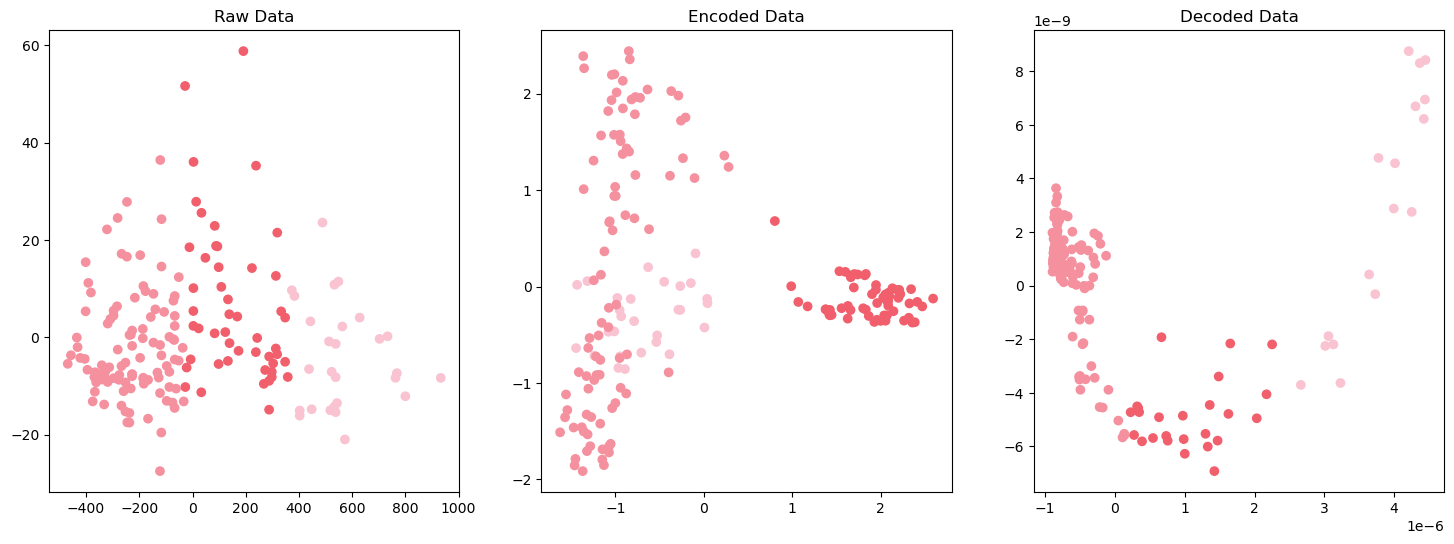

In [21]:
print('Plot of KMeans Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Iris

In [22]:
# Load Data 
iris = load_iris()

features = iris.data
labels = iris.target

### Raw Data (Baseline)

In [23]:
kmeans_raw, kmean_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [24]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [25]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0606
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [26]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [27]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [28]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [29]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [30]:
encoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 150, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 19, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 150, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 19, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 38, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 38, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 76, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 76, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 152, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 150, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [32]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [33]:
print('Summary of KMeans Results (Iris Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (Iris Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards),Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.893333,0.767167,0.731199,558.058041,0.554324,0.656256,NaN,NaN,NaN,NaN,NaN,NaN
1,Decoded Data,NaN,NaN,NaN,NaN,NaN,NaN,0.973333,0.899884,0.922177,320.550365,0.467575,0.965387
2,Decoded Data,NaN,NaN,NaN,NaN,NaN,NaN,0.960000,0.860547,0.885665,546.880754,0.569176,0.706043


Plot of KMeans Clustering (Wine Dataset


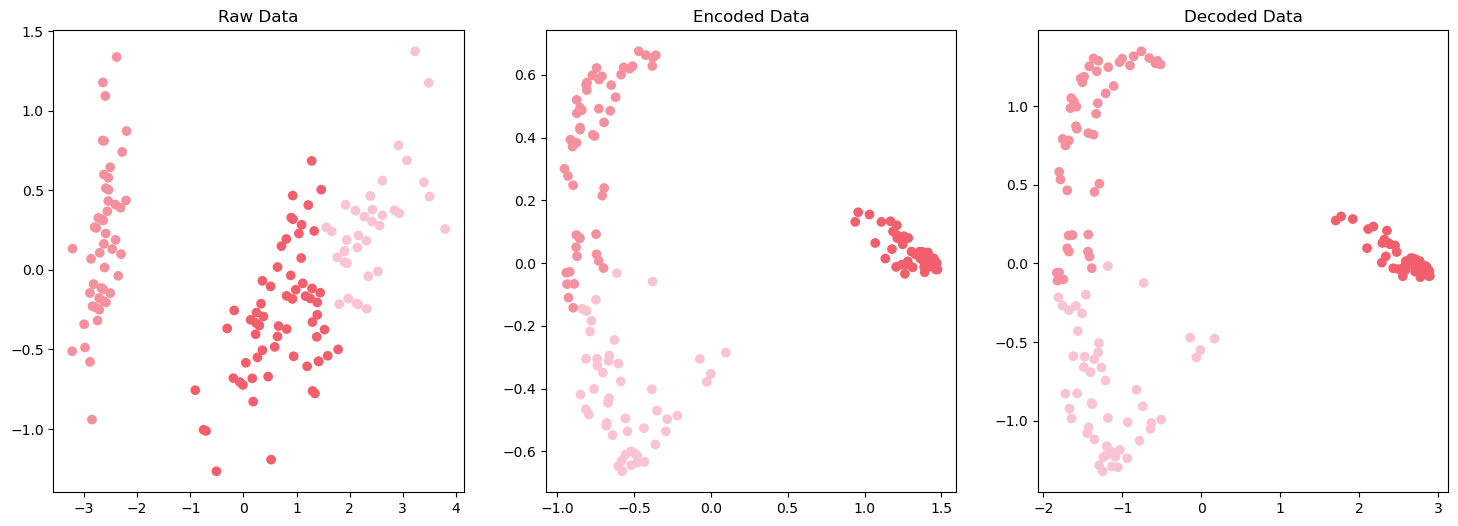

In [34]:
print('Plot of KMeans Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Yeast

In [35]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [36]:
# fetch dataset 
yeast = fetch_ucirepo(id=110) 

In [37]:
# Load Data 
features = yeast.data.features 
labels = yeast.data.targets 

In [38]:
# Encode class labels
labels = encode_labels(labels)

### Raw Data (Baseline)

In [39]:
kmeans_raw, kmean_labels_raw = kmeans_clustering(features, labels, 'Raw Data')

### Encoded Data

In [40]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [41]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0299
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [42]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [43]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [44]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [45]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [46]:
encoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1484, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1484, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 742, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 742, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 371, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 371, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 186, 256)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1484, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1484, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 742, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 742, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 371, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 371, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 186, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 186, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 372, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 372, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 744, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 744, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_8 (UpSampling1D)  │ (None, 1488, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1488, 1)        │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_2 (Cropping1D)       │ (None, 1484, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [48]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [49]:
print('Summary of KMeans Results (Yeast Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (Yeast Dataset)


,Input Data,Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.512803,0.247465,0.141137,282.518939,0.174387,1.336251
1,Decoded Data,0.456199,0.186225,0.085000,276.354122,0.178196,1.527875
2,Decoded Data,0.442049,0.169012,0.100291,749.961293,0.243002,1.165566


Plot of KMeans Clustering (Wine Dataset


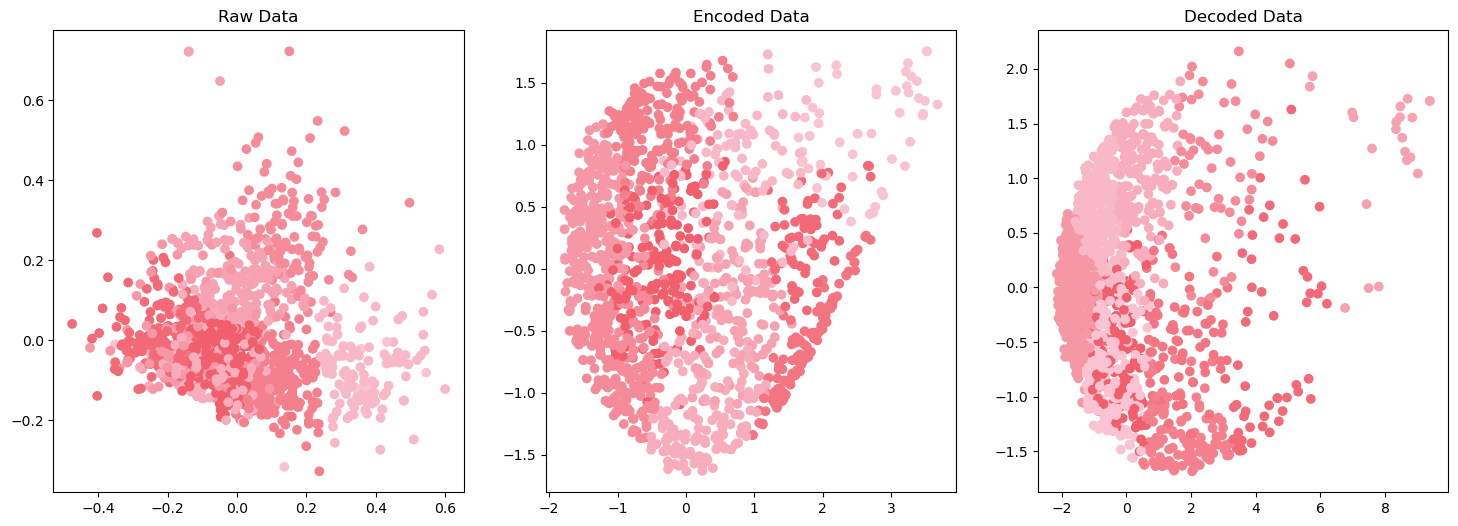

In [50]:
print('Plot of KMeans Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Glass

In [51]:
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 

In [52]:
# Load Data 
features = glass_identification.data.features 
labels = glass_identification.data.targets 

In [53]:
# Encode class labels
labels = encode_labels(labels, encode=False)

### Raw Data (Baseline)

In [54]:
kmeans_raw, kmean_labels_raw = kmeans_clustering(features, labels, 'Raw Data')

### Encoded Data

In [55]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [56]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0548
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [57]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [58]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [59]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [60]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [61]:
encoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 214, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 214, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 107, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 27, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 214, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 214, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 107, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 27, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_9 (UpSampling1D)  │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 54, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_10 (UpSampling1D) │ (None, 108, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 108, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_11 (UpSampling1D) │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 216, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_3 (Cropping1D)       │ (None, 214, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [63]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [64]:
print('Summary of KMeans Results (Glass Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (Glass Dataset)


,Input Data,Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.537383,0.407471,0.246405,95.558436,0.572517,1.016376
1,Decoded Data,0.546729,0.359651,0.208861,178.005799,0.297823,1.309656
2,Decoded Data,0.532710,0.356896,0.223144,359.143180,0.411587,0.985972


Plot of KMeans Clustering (Wine Dataset


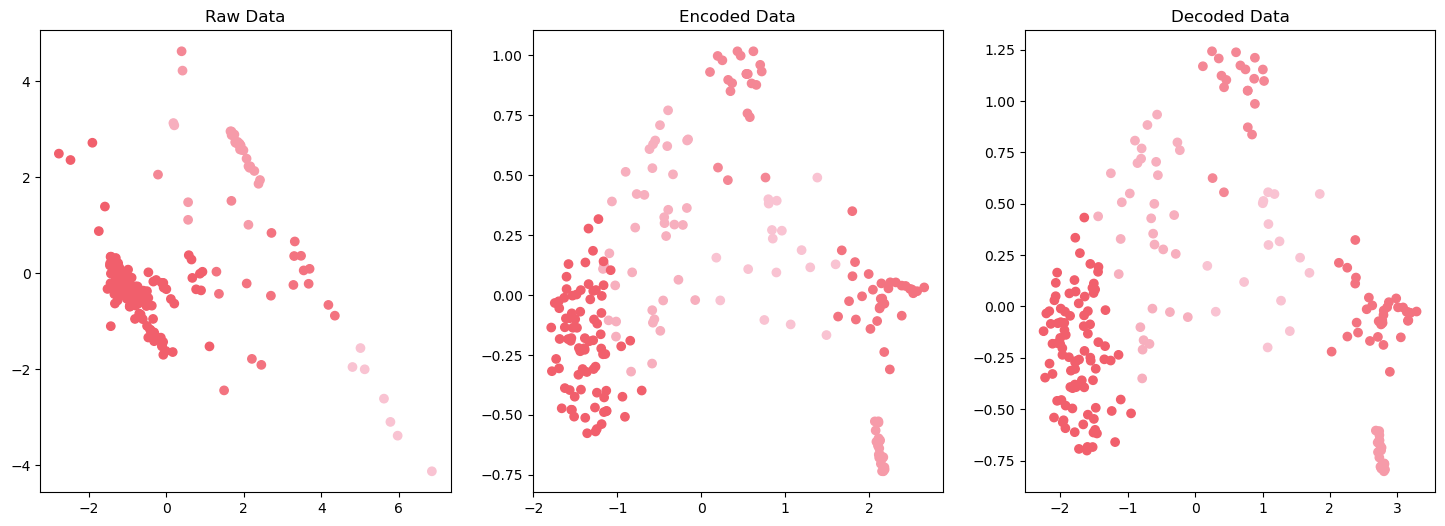

In [65]:
print('Plot of KMeans Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Breast Cancer Wisconsin (Original)

In [66]:
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

In [67]:
# Load Data 
features = breast_cancer_wisconsin_original.data.features 
labels = breast_cancer_wisconsin_original.data.targets 

In [68]:
# Encode class labels
labels = encode_labels(labels, encode=False)

In [70]:
# Create a mask to identify rows with no NA values in features
mask = ~np.isnan(features).any(axis=1)  # Check for any NA in each row

# Apply the mask to both features and labels to keep only valid rows
features = features[mask]
labels= labels[mask]

### Raw Data (Baseline)

In [71]:
kmeans_raw, kmean_labels_raw = kmeans_clustering(features, labels, 'Raw Data')

### Encoded Data

In [72]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [73]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0498
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [74]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [75]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [76]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [77]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [78]:
encoder.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 683, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 683, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 342, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 342, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 171, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 171, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 86, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
autoencoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 683, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 683, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 342, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 342, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 171, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 171, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 86, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 86, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_12 (UpSampling1D) │ (None, 172, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 172, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_13 (UpSampling1D) │ (None, 344, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 344, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_14 (UpSampling1D) │ (None, 688, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 688, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_4 (Cropping1D)       │ (None, 683, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [80]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [81]:
print('Summary of KMeans Results (BCW (Original) Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (BCW (Original) Dataset)


,Input Data,Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.960469,0.747541,0.846468,1026.262388,0.596798,0.757259
1,Decoded Data,0.923865,0.672643,0.717723,802.430754,0.461723,0.810449
2,Decoded Data,0.922401,0.668646,0.712772,1079.296483,0.524413,0.682722


Plot of KMeans Clustering (Wine Dataset


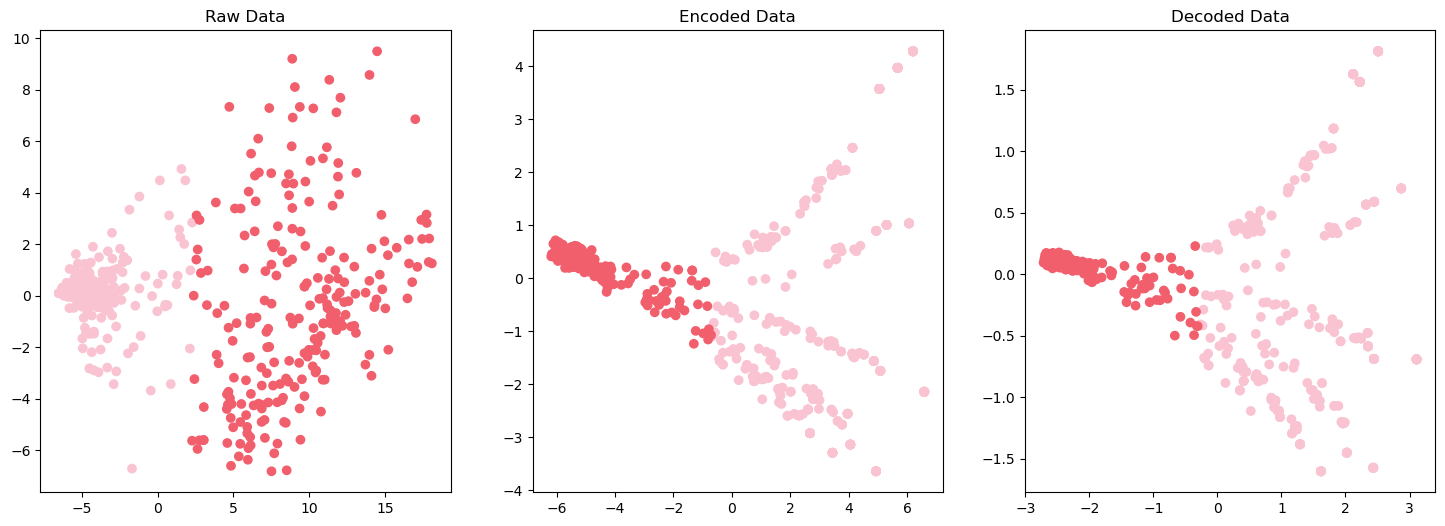

In [82]:
print('Plot of KMeans Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Breast Cancer Wisconsin (Diagnostic)

In [83]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

In [84]:
# Load Data 
features = breast_cancer_wisconsin_diagnostic.data.features 
labels = breast_cancer_wisconsin_diagnostic.data.targets 

In [85]:
# Encode class labels
labels = encode_labels(labels, encode=True)

### Raw Data (Baseline)

In [86]:
kmeans_raw, kmean_labels_raw = kmeans_clustering(features, labels, 'Raw Data')

### Encoded Data

In [87]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [88]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0591
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [89]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [90]:
kmeans_encoded, kmean_labels_encoded = kmeans_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [91]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [92]:
kmeans_decoded, kmean_labels_decoded = kmeans_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [93]:
encoder.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 569, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 569, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 285, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 285, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 143, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 143, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 72, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
autoencoder.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 569, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 569, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 285, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 285, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 143, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 143, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 72, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_15 (UpSampling1D) │ (None, 144, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 144, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_16 (UpSampling1D) │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 288, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_17 (UpSampling1D) │ (None, 576, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 576, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_5 (Cropping1D)       │ (None, 569, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [95]:
kmeans_summary = []

kmeans_summary.append(kmeans_raw)
kmeans_summary.append(kmeans_encoded)
kmeans_summary.append(kmeans_decoded)

In [96]:
print('Summary of KMeans Results (BCW (Diagnostic) Dataset)')
pd.DataFrame(kmeans_summary)

Summary of KMeans Results (BCW (Diagnostic) Dataset)


,Input Data,Purity (KMeans),AMI (KMeans),ARI (KMeans),Calinski-Harabasz Index (KMeans),Silhouette Coefficient (KMeans),Davies-Bouldin Index (KMeans)
0,Raw Data,0.854130,0.464005,0.491425,1300.208227,0.697265,0.504404
1,Decoded Data,0.898067,0.545083,0.632883,20.714952,0.036217,5.189043
2,Decoded Data,0.657293,0.056237,0.045574,4358.842707,0.927036,0.174351


Plot of KMeans Clustering (BCW (Diagnostic) Dataset


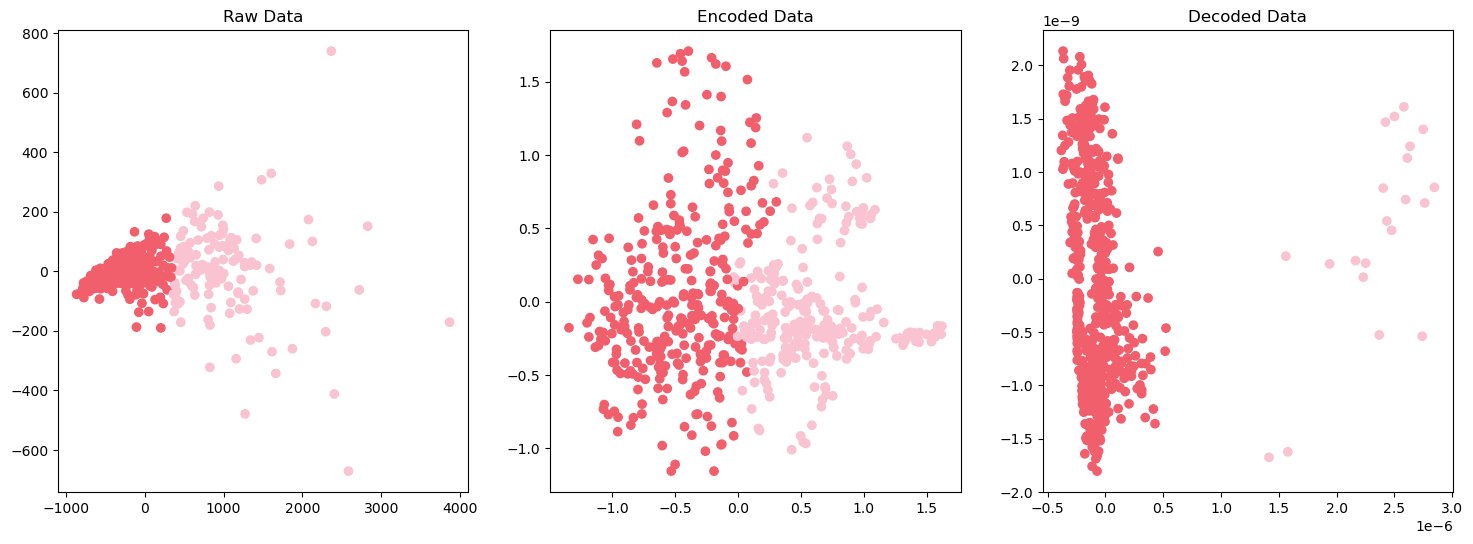

In [97]:
print('Plot of KMeans Clustering (BCW (Diagnostic) Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, kmean_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, kmean_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, kmean_labels_decoded, axs[2], title='Decoded Data')

plt.show()

# Ward's Method

## Wine

In [98]:
# Load Wine Data 
wine = load_wine()

features = wine.data
labels = wine.target

### Raw Data (Baseline)

In [99]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [100]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [101]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1140
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [102]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [103]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [104]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [105]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [106]:
encoder.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 89, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 23, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
autoencoder.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 89, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 23, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_18 (UpSampling1D) │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 46, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_19 (UpSampling1D) │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 92, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_20 (UpSampling1D) │ (None, 184, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 184, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_6 (Cropping1D)       │ (None, 178, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [108]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [109]:
print('Summary of Wards Method Results (Wine Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (Wine Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.696629,0.409868,0.368402,552.851712,0.564480,0.535734
1,Decoded Data,0.926966,0.830022,0.803345,29.479036,0.179981,2.244636
2,Decoded Data,0.657303,0.426692,0.271699,1264.853299,0.773905,0.424401


Plot of Wards Method Clustering (Wine Dataset


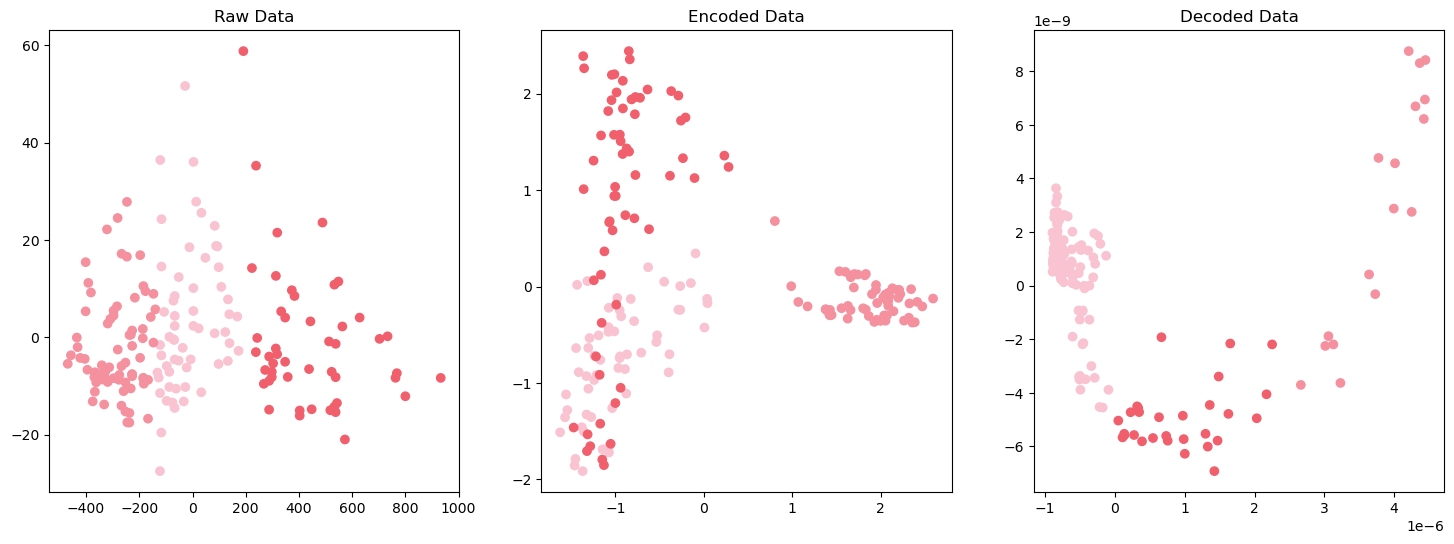

In [110]:
print('Plot of Wards Method Clustering (Wine Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Iris

In [111]:
# Load Data 
iris = load_iris()

features = iris.data
labels = iris.target

### Raw Data (Baseline)

In [112]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [113]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [114]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0606
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [115]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [116]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [117]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [118]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [119]:
encoder.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 150, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 19, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
autoencoder.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 150, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 19, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_21 (UpSampling1D) │ (None, 38, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 38, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_22 (UpSampling1D) │ (None, 76, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 76, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_23 (UpSampling1D) │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 152, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_7 (Cropping1D)       │ (None, 150, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [121]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [122]:
print('Summary of Wards Method Results (Iris Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (Iris Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.893333,0.767167,0.731199,558.058041,0.554324,0.656256
1,Decoded Data,0.900000,0.795421,0.745504,311.593483,0.469091,0.950782
2,Decoded Data,0.913333,0.811464,0.773380,545.319250,0.578345,0.683828


Plot of Wards Method Clustering (Iris Dataset


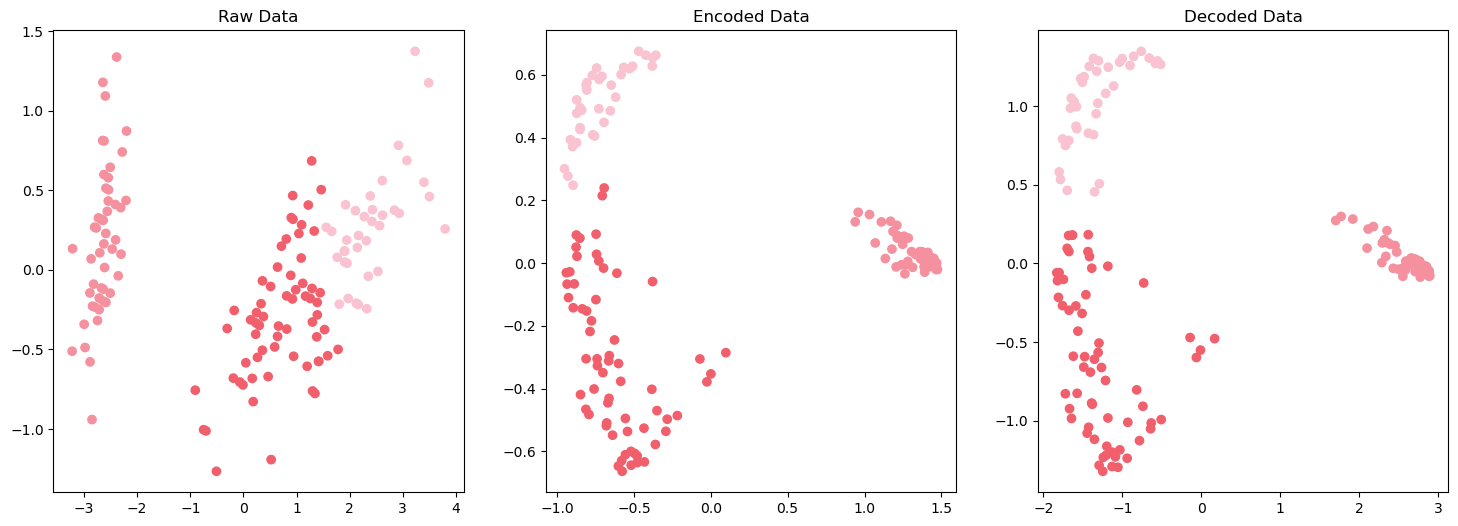

In [123]:
print('Plot of Wards Method Clustering (Iris Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Yeast

In [125]:
# fetch dataset 
yeast = fetch_ucirepo(id=110) 

In [126]:
# Load Data 
features = yeast.data.features 
labels = yeast.data.targets 

In [127]:
# Encode class labels
labels = encode_labels(labels)

### Raw Data (Baseline)

In [128]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [129]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [130]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0299
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [131]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [132]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [133]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [134]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [135]:
encoder.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1484, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 1484, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 742, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 742, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 371, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 371, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 186, 256)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
autoencoder.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1484, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 1484, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 742, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 742, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 371, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 371, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 186, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 186, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_24 (UpSampling1D) │ (None, 372, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 372, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_25 (UpSampling1D) │ (None, 744, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 744, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_26 (UpSampling1D) │ (None, 1488, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, 1488, 1)        │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_8 (Cropping1D)       │ (None, 1484, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [137]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [138]:
print('Summary of Wards Method Results (Yeast Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (Yeast Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.485849,0.220345,0.107097,235.034045,0.135577,1.483180
1,Decoded Data,0.466981,0.197455,0.099566,227.821183,0.154945,1.755448
2,Decoded Data,0.429245,0.168990,0.093169,632.188621,0.175834,1.309183


Plot of Wards Method Clustering (Yeast Dataset


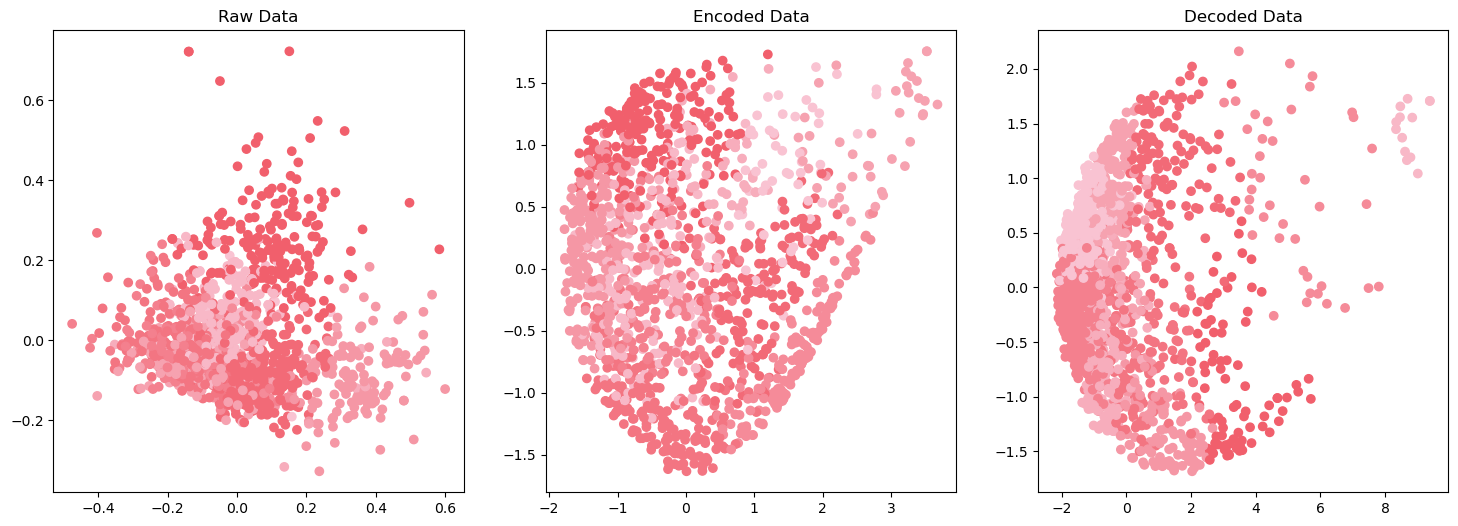

In [139]:
print('Plot of Wards Method Clustering (Yeast Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Glass

In [140]:
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 

In [141]:
# Load Data 
features = glass_identification.data.features 
labels = glass_identification.data.targets 

In [142]:
# Encode class labels
labels = encode_labels(labels, encode=False)

### Raw Data (Baseline)

In [143]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [144]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [145]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0548
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [146]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [147]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [148]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [149]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [150]:
encoder.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 214, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 214, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 107, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 27, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
autoencoder.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 214, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 214, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 107, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 54, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 27, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_27 (UpSampling1D) │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 54, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_28 (UpSampling1D) │ (None, 108, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 108, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_29 (UpSampling1D) │ (None, 216, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 216, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_9 (Cropping1D)       │ (None, 214, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [152]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [153]:
print('Summary of Wards Method Results (Glass Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (Glass Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.542056,0.365099,0.262031,118.711158,0.462192,0.981729
1,Decoded Data,0.621495,0.333227,0.226261,178.272184,0.261168,1.330899
2,Decoded Data,0.621495,0.341739,0.211607,342.600299,0.331822,1.062408


Plot of Wards Method Clustering (Glass Dataset


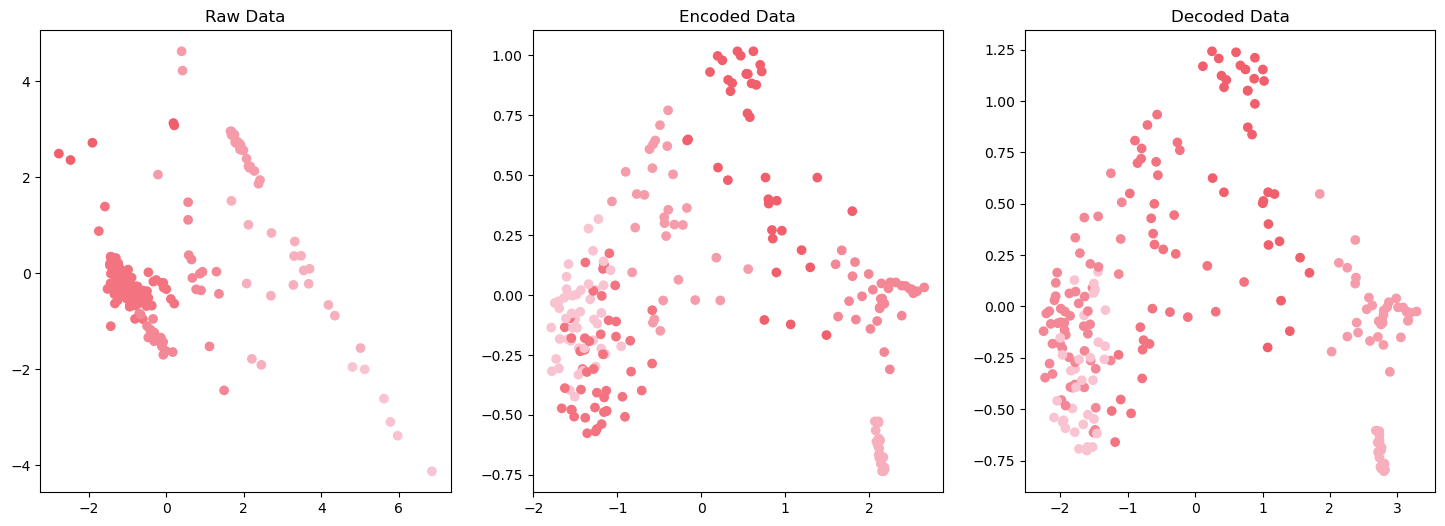

In [154]:
print('Plot of Wards Method Clustering (Glass Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Breast Cancer Wisconsin (Original)

In [155]:
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

In [156]:
# Load Data 
features = breast_cancer_wisconsin_original.data.features 
labels = breast_cancer_wisconsin_original.data.targets 

In [157]:
# Encode class labels
labels = encode_labels(labels, encode=False)

In [159]:
# Create a mask to identify rows with no NA values in features
mask = ~np.isnan(features).any(axis=1)  # Check for any NA in each row

# Apply the mask to both features and labels to keep only valid rows
features = features[mask]
labels= labels[mask]

### Raw Data (Baseline)

In [160]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [161]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [162]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0498
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [163]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [164]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [165]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [166]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [167]:
encoder.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 683, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 683, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 342, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 342, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 171, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 171, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 86, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
autoencoder.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 683, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 683, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 342, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 342, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 171, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 171, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 86, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 86, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_30 (UpSampling1D) │ (None, 172, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 172, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_31 (UpSampling1D) │ (None, 344, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 344, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_32 (UpSampling1D) │ (None, 688, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 688, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_10 (Cropping1D)      │ (None, 683, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [169]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [170]:
print('Summary of Wards Method Results (BCW (Original) Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (BCW (Original) Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.966325,0.802844,0.868999,907.288932,0.567330,0.789735
1,Decoded Data,0.961933,0.763171,0.852451,716.399620,0.439152,0.791302
2,Decoded Data,0.944363,0.733483,0.788884,1059.218768,0.522873,0.665005


Plot of Wards Method Clustering (BCW (Original) Dataset


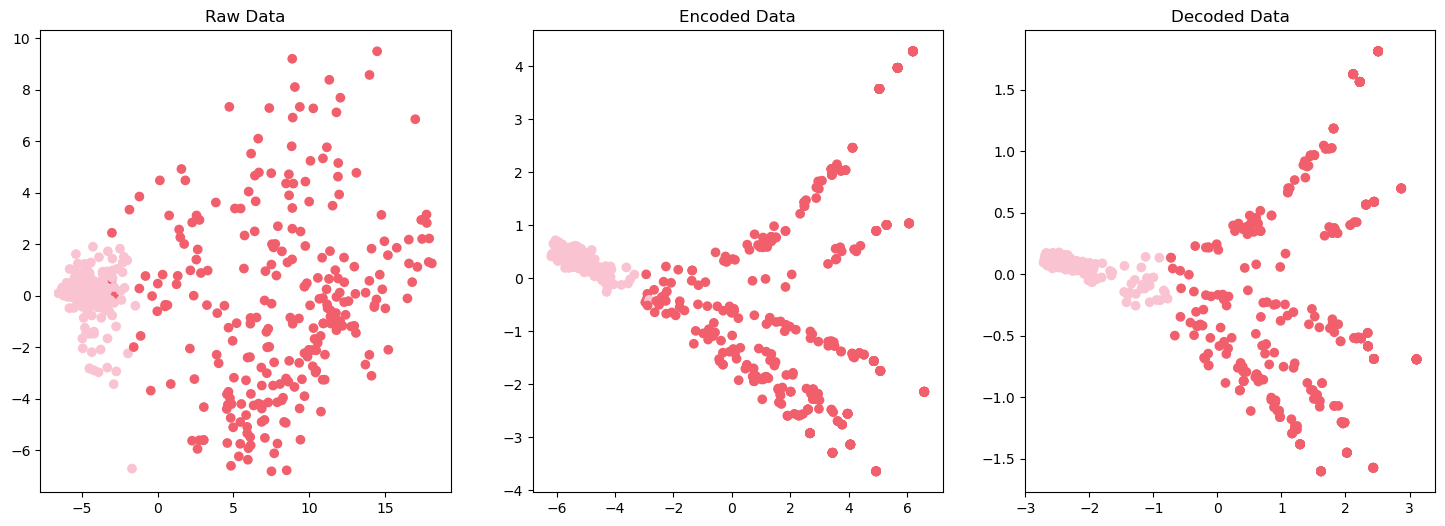

In [171]:
print('Plot of Wards Method Clustering (BCW (Original) Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()

## Breast Cancer Wisconsin (Diagnostic)

In [172]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

In [173]:
# Load Data 
features = breast_cancer_wisconsin_diagnostic.data.features 
labels = breast_cancer_wisconsin_diagnostic.data.targets 

In [174]:
# Encode class labels
labels = encode_labels(labels, encode=True)

### Raw Data (Baseline)

In [175]:
wards_raw, wards_labels_raw = wards_clustering(features, labels, 'Raw Data')

### Encoded Data

In [176]:
# Similarity Matrix 
sim_matrix = compute_similarity_matrix(features, 'euclidean')

In [177]:
# Get encoded and decoded features

set_random_seed(69)
encoded_data, decoded_data, encoder, autoencoder = cnn_autoencoder(sim_matrix)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0591
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [178]:
# Flatten encoded features
encoded_flat = encoded_data.reshape(encoded_data.shape[0], -1)

In [179]:
wards_encoded, wards_labels_encoded = wards_clustering(encoded_flat, labels,
                                                  'Decoded Data')

### Decoded Data

In [180]:
# Flatten decoded features
decoded_flat = decoded_data.reshape(decoded_data.shape[0], -1)

In [181]:
wards_decoded, wards_labels_decoded = wards_clustering(
    decoded_flat, labels, 'Decoded Data')

### Summary

In [182]:
encoder.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 569, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 569, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 285, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_78 (Conv1D)              │ (None, 285, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 143, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 143, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 72, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,520 (482.50 KB)

 Trainable params: 123,520 (482.50 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
autoencoder.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 569, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 569, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 285, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_78 (Conv1D)              │ (None, 285, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 143, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 143, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_80 (Conv1D)              │ (None, 72, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_33 (UpSampling1D) │ (None, 144, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 144, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_34 (UpSampling1D) │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 288, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_35 (UpSampling1D) │ (None, 576, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 576, 1)         │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_11 (Cropping1D)      │ (None, 569, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,949 (5.08 MB)

 Trainable params: 443,649 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 887,300 (3.38 MB)

In [184]:
wards_summary = []

wards_summary.append(wards_raw)
wards_summary.append(wards_encoded)
wards_summary.append(wards_decoded)

In [185]:
print('Summary of Wards Method Results (BCW (Diagnostic) Dataset)')
pd.DataFrame(wards_summary)

Summary of Wards Method Results (BCW (Diagnostic) Dataset)


,Input Data,Purity (Wards),AMI (Wards),ARI (Wards),Calinski-Harabasz Index (Wards),Silhouette Coefficient (Wards),Davies-Bouldin Index (Wards)
0,Raw Data,0.778559,0.317970,0.287246,1088.162361,0.689980,0.479464
1,Decoded Data,0.681898,0.061792,0.105215,16.894539,0.033951,4.169328
2,Decoded Data,0.657293,0.056237,0.045574,4358.842707,0.927036,0.174351


Plot of Wards Method Clustering (BCW (Diagnostic) Dataset


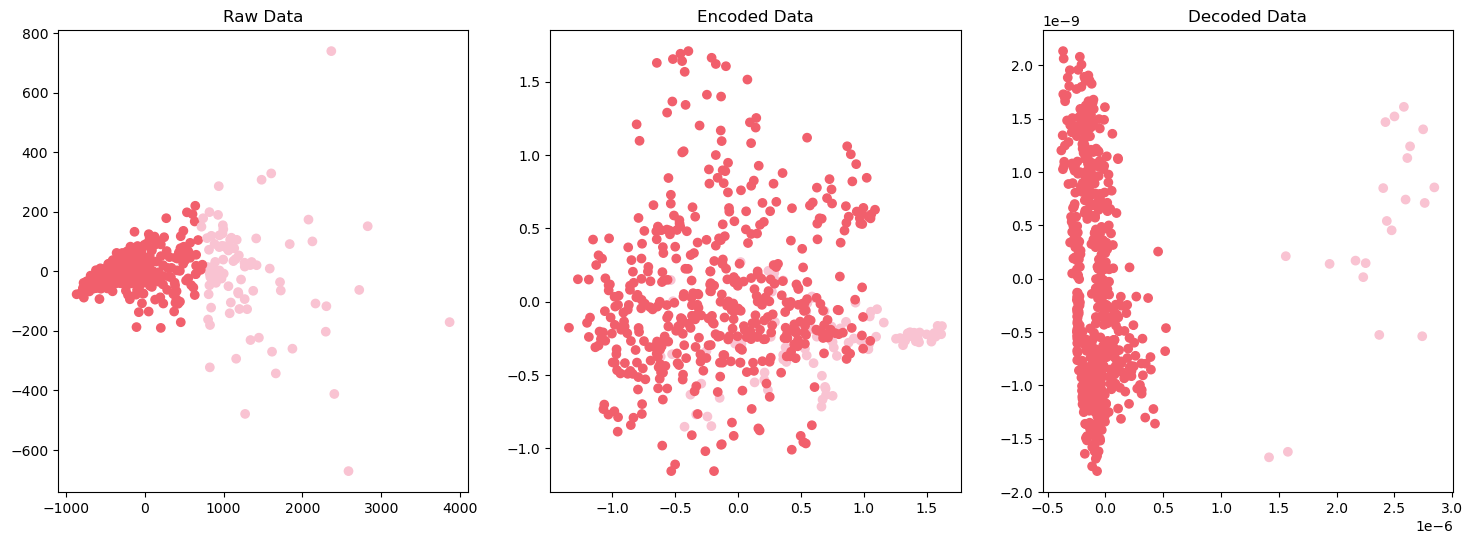

In [186]:
print('Plot of Wards Method Clustering (BCW (Diagnostic) Dataset')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
plot_clusters(features, wards_labels_raw, axs[0], title='Raw Data')
plot_clusters(encoded_flat, wards_labels_encoded, axs[1], title='Encoded Data')
plot_clusters(decoded_flat, wards_labels_decoded, axs[2], title='Decoded Data')

plt.show()